# FIT5226 Project

## Stage 3 - Multi-agent learning of a coordination problem
***

### Contract

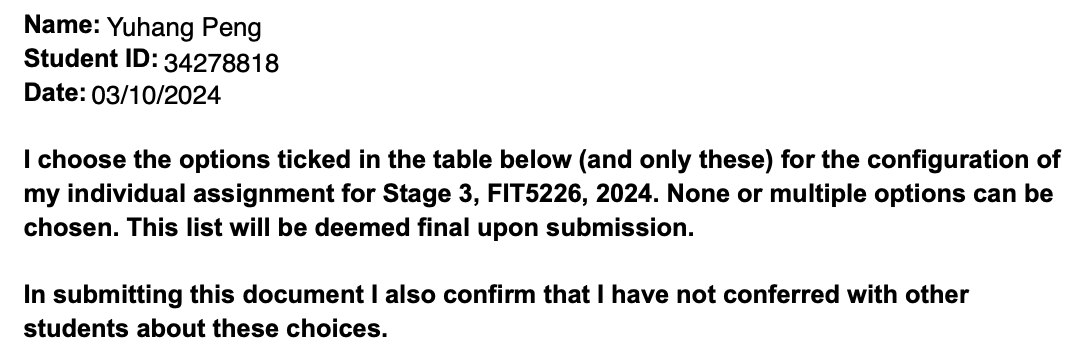
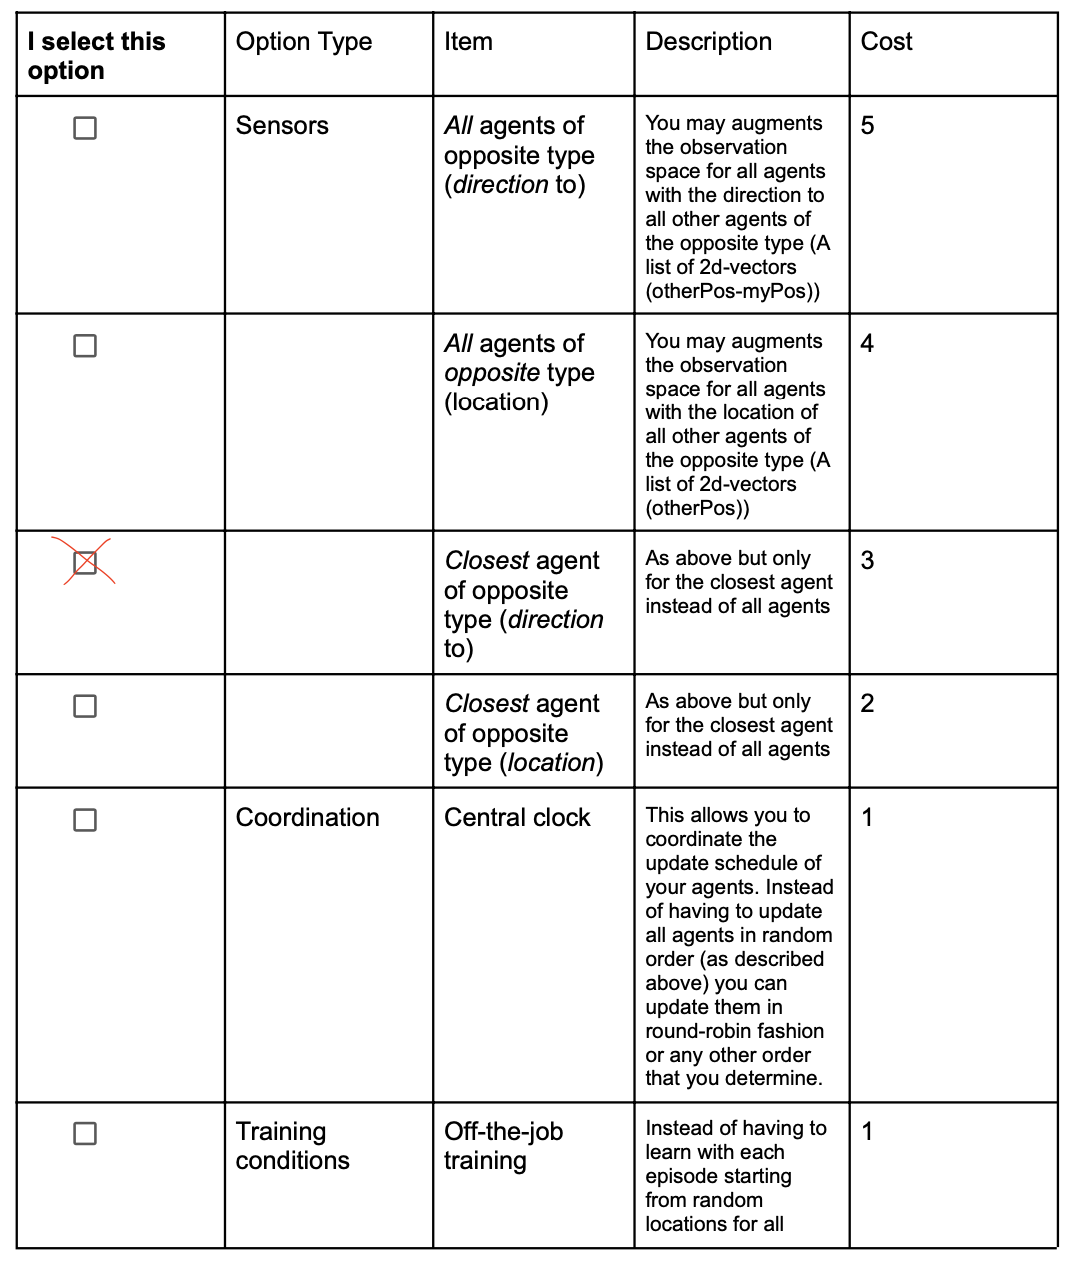
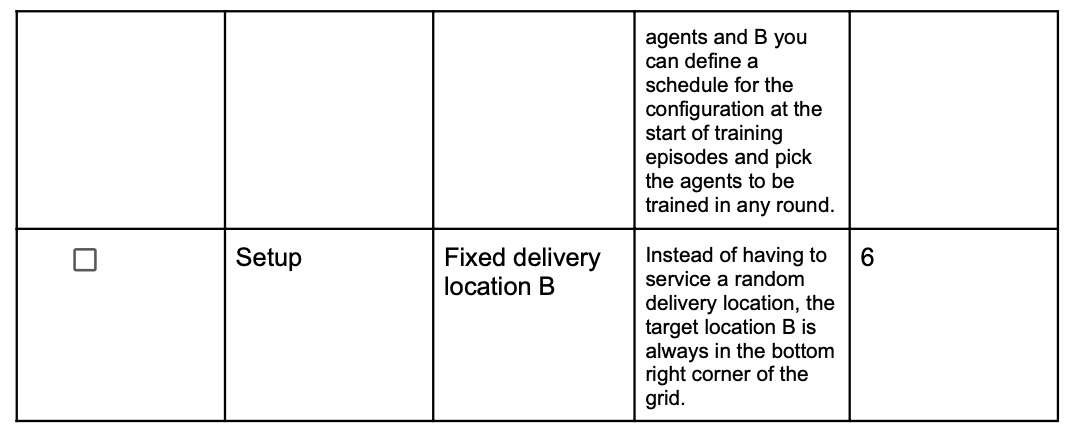

### 1. Imports

The following scripts imports essential libraries including `numpy` for numerical operations, `random` for generating random values, `torch` for deep learning operations, `copy` for handling deep object copying, `time` for tracking execution time, and `csv` for exporting the information of failure cases to the csv file for future analysis. Additionally, it uses `matplotlib.pyplot` for data visualisation, `mpatches` and `ListedColormap` for customising plot elements, and `FuncAnimation` from `matplotlib.animation` for creating dynamic visualisations.

In [1]:
# Use the TkAgg backend in matplotlib to display both plots and animations.
import matplotlib
matplotlib.use('TkAgg')

In [2]:
# Importing the required libraries
import numpy as np
import random
import torch
import copy
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

***

### 2. Environment Setup

In this project, the GridWorld class simulates an environment where multiple agents collaborate to achieve a common goal. The environment consists of a square grid (default size: 5x5) and multiple agents. The agents must work together to transport items to a specific location (B) while exchanging secret information required to complete the task.

#### GridWorld Setup
- **Grid**: The environment is a configurable grid world of size $n \times n$. The default size is $5 \times 5$, but it can be adjusted based on experimental requirements. Each cell in the grid represents a possible location that agents can occupy. Larger grid sizes result in more complex movement patterns and require agents to navigate longer distances.
- **Agents**: There are two types of agents in the environment: Type 0 and Type 1. Type 0 agents possess the first half of the secret, while Type 1 agents possess the second half. Agents are initialized at random positions on the grid, ensuring they do not start at the target location. This distribution encourages agents to collaborate and exchange secrets to complete the task.
- **Starting Positions**: Each agent starts at a random position on the grid. Each agent should not start at the target location. The target location (B) is also randomly selected for each episode.
- **Actions**: Agents can execute the following actions:
    - Move north, south, east, or west.
    - Stay in place.
- **Movement Restrictions**: Agents cannot move outside the boundaries of the grid. Each movement action is bounded within the grid size.

#### Task Objective
- Agents must collaborate to deliver an item to location B. However, delivering the item requires both agents to possess the full secret, which can only be obtained by exchanging partial secrets with an agent of the opposite type.
- **Secret Exchange**: When agents of different types meet on the same grid square, they automatically exchange secrets.
- **Item Delivery**: Once an agent has the full secret, it can deliver the item to the target location B.

#### State Space
The state space for each agent consists of the following components:
1. **Agent Location**: Represents the current position of the agent on the grid.
2. **Target Location**: The position that agents must deliver. This target is randomized for each episode.
3. **Direction to Target**: Calculated as the relative direction from the agent’s current position to the target, guiding movement.
4. **Relative Position (Direction to) Nearest Opposite-Type Agent**: Agents use this to determine where the nearest agent of the opposite type is located, crucial for secret exchange.
5. **Secret Possession Status**: A boolean that indicates whether the agent has already obtained the full secret, influencing task completion.

#### Action Space
The action space for each agent consists of five possible actions:

1. **Move North**: Move one grid cell upward.
2. **Move South**: Move one grid cell downward.
3. **Move East**: Move one grid cell to the right.
4. **Move West**: Move one grid cell to the left.
5. **Stay**: Remain in the current position.

Agents must choose their actions carefully to avoid unnecessary penalties, such as hitting walls or taking too many steps, which incur negative rewards.

#### Reward Structure

The reward structure is designed to incentivize efficient task completion:

1. **Step Penalty (-1)**: Discourages agents from taking excessive steps, pushing them to find the shortest path.
2. **Wall Penalty (-5)**: Penalizes agents for attempting to move outside the grid, ensuring they learn boundary constraints.
3. **Secret Exchange Reward (+10)**: Rewards agents for successfully exchanging secrets, encouraging collaboration between different agent types.
4. **Task Completion Reward (+100)**: A significant reward given to an agent that delivers the item to the target location with the full secret, reinforcing the task objective.

#### Completion Conditions

The episode ends when one of the following conditions is met:

- An agent with the full secret reaches the target location, successfully completing the task.
- The predefined step limit is reached without successful task completion, leading to episode failure and an overall penalty for inefficient task execution.

In [3]:
class GridWorld:
    def __init__(self, size=5, num_agents=4):
        """
        Initialize the GridWorld environment.
        """
        self.size = size # Define the grid size
        self.num_agents = num_agents # Define the number of agents
        self.reset() # Reset the environment

    def reset(self):
        """
        Reset the environment, setting up agent locations, target locations,
        and initializing other state variables.
        """
        self.agent_locations = [] # List to store the location of all agents
        self.target_location = self._random_position() # Random target location
        self.agent_types = [i % 2 for i in range(self.num_agents)] # Assign agent types (0 or 1)

        # Initialize agent positions ensuring different types of agents don't start in the same cell
        for i in range(self.num_agents):
            pos = self._random_position()
            # Ensure valid agent position
            while pos == self.target_location:
                pos = self._random_position()
            self.agent_locations.append(pos)

        self.agent_has_secret = [False] * self.num_agents # Track whether each agent has the full secret
        self.done = False # Flag to indicate if the task is completed
        return self._get_state()

    def _random_position(self):
        """
        Generate a random position within the grid.
        """
        return (random.randint(0, self.size - 1), random.randint(0, self.size - 1))

    def _get_state(self):
        """
        Get the current state of the environment for all agents.
        """
        states = []
        for i in range(self.num_agents):
            agent_loc = self.agent_locations[i]
            direction_to_target = (
                self.target_location[0] - agent_loc[0],
                self.target_location[1] - agent_loc[1]
            )
            # Get the nearest agent of the opposite type
            nearest_agent_position = self._get_nearest_agent(i)
            relative_position = (
                nearest_agent_position[0] - agent_loc[0],
                nearest_agent_position[1] - agent_loc[1]
            ) if nearest_agent_position else (0, 0)

            # Construct the agent's state
            state = [
                agent_loc[0], agent_loc[1], # Agent's current position
                self.target_location[0], self.target_location[1], # Target position
                direction_to_target[0], direction_to_target[1], # Direction to the target
                relative_position[0], relative_position[1], # Relative position to nearest opposite-type agent
                int(self.agent_has_secret[i]) # Whether the agent possesses the full secret
            ]
            states.append(np.array(state))
        return states

    def _get_nearest_agent(self, agent_idx):
        """
        Find the nearest agent of the opposite type for a given agent.
        """
        agent_loc = self.agent_locations[agent_idx]
        min_distance = self.size * 2 # Set to maximum possible distance initially
        nearest_agent_position = None

        # Iterate over all agents to find the nearest one of the opposite type
        for j in range(self.num_agents):
            if agent_idx != j and self.agent_types[agent_idx] != self.agent_types[j]:
                other_agent_loc = self.agent_locations[j]
                distance = abs(other_agent_loc[0] - agent_loc[0]) + abs(other_agent_loc[1] - agent_loc[1])
                if distance < min_distance:
                    min_distance = distance
                    nearest_agent_position = other_agent_loc
        return nearest_agent_position

    def step(self, actions):
        """
        Execute a step in the environment where all agents take their respective actions.
        """
        action_map = ['north', 'south', 'west', 'east', 'stay']
        rewards = [0] * self.num_agents # Initialize rewards for each agent

        # Shuffle the agents to randomize their movement order
        agent_indices = list(range(self.num_agents))
        random.shuffle(agent_indices)

        # Move each agent according to its action
        for idx in agent_indices:
            action = actions[idx]
            new_y, new_x = self._get_new_position(self.agent_locations[idx], action_map[action])

            # Check if the new position is within the grid boundaries
            if 0 <= new_x < self.size and 0 <= new_y < self.size:
                self.agent_locations[idx] = (new_y, new_x)
                rewards[idx] -= 1 # Penalty for each movement
            else:
                rewards[idx] -= 5 # Penalty for hitting a wall

        # Check if agents interact (meet at the same position)
        self._check_interaction(rewards)

        # Check if any agent has the secret and reaches the target location
        for idx in range(self.num_agents):
            if self.agent_has_secret[idx] and self.agent_locations[idx] == self.target_location:
                rewards[idx] += 100 # Reward for completing the task
                self.done = True # Task completion flag
                break

        next_states = self._get_state()
        dones = [self.done] * self.num_agents # All agents receive the same completion signal

        return next_states, rewards, dones, agent_indices

    def _get_new_position(self, position, action):
        """
        Calculate the new position of the agent based on the action taken.
        """
        y, x = position
        if action == 'north':
            return y - 1, x # Move up
        elif action == 'south':
            return y + 1, x # Move down
        elif action == 'west':
            return y, x - 1 # Move left
        elif action == 'east':
            return y, x + 1 # Move right
        else:  # stay
            return y, x # Stay in place

    def _check_interaction(self, rewards):
        """
        Check if two agents are on the same grid cell (interaction),
        and if they are of different types, they exchange secrets.
        """
        # Iterate over every pair of agents to check if they are in the same location
        for i in range(self.num_agents):
            for j in range(i + 1, self.num_agents):
                if self.agent_locations[i] == self.agent_locations[j]:
                    # Ensure they are of different types and are not at the target location
                    if self.agent_types[i] != self.agent_types[j] and self.agent_locations[i] != self.target_location:
                        # If either of the two agents has not exchanged secrets yet, initiate the secret exchange
                        if not (self.agent_has_secret[i] and self.agent_has_secret[j]):
                            # Only add reward for their first exchange
                            if not self.agent_has_secret[i]:
                                self.agent_has_secret[i] = True
                                rewards[i] += 10
                            if not self.agent_has_secret[j]:
                                self.agent_has_secret[j] = True
                                rewards[j] += 10

***

### 3. Deep Q-Learning Algorithm

Deep Q-Learning is a reinforcement learning algorithm that uses a neural network to approximate the Q-value function, enabling agents to learn optimal policies in large state spaces. Unlike traditional Q-Learning, which relies on a Q-table, DQL uses a neural network to predict Q-values for each action, allowing it to handle environments with continuous or large discrete state spaces. In this project, DQL is used to train agents to collaborate and complete tasks efficiently in a grid world environment.

#### DeepQAgent Class
The `DeepQAgent` class is a model-free reinforcement learning agent (learning from experiences) that uses a neural network to approximate the Q-value function. This enables the agent to estimate the optimal action for each state, rather than relying on a traditional Q-table.

#### Agent Initialization

The `DeepQAgent` is initialized with several important parameters that control the learning process:

- **State Size**: The size of the state vector that represents the agent’s observation of the environment.
- **Action Size**: The number of possible actions the agent can take (e.g., move in four directions or stay).
- **Discount Factor (gamma, $\gamma$)**: This determines how much the agent values future rewards compared to immediate rewards. A higher $\gamma$ encourages the agent to focus on long-term rewards, while a lower $\gamma$ prioritizes short-term gains.
- **Exploration Rate (epsilon, $\epsilon$)**: Controls the balance between exploration (choosing random actions) and exploitation (choosing the action with the highest Q-value). Initially, the agent explores more, but over time, $\epsilon$ decays, encouraging the agent to exploit its learned policy.
- **epsilon_decay**: The rate at which epsilon decays after each episode or step, allowing the agent to gradually shift from exploration to exploitation as it learns.
- **min_epsilon**: The minimum exploration rate the agent will reach during training, preventing it from fully stopping exploration.
- **replay_buffer_size**: Specifies the maximum number of experiences that can be stored in the replay buffer.
- **batch_size**: The number of samples randomly drawn from the replay buffer during each training step. This determines the amount of data used to update the Q-values.
- **Learning Rate (lr)**: Controls how much the agent updates its Q-values during training. A higher learning rate may lead to faster learning but can cause instability, while a lower rate can slow down learning but improve stability.
- **copy_freq**: The frequency (in steps) at which the target network is updated to match the current network’s weights.

#### Neural Network Architecture

The agent’s Q-value function is approximated by a neural network consisting of two fully connected hidden layers:

- **First Layer**: 150 neurons with ReLU activation. This layer captures complex features from the input state.
- **Second Layer**: 100 neurons with ReLU activation. This layer further refines the features before the output.
- **Output Layer**: The output layer contains one neuron per possible action, representing the estimated Q-value for each action.

The `ReLU` activation function is used in the hidden layers because it introduces non-linearity, allowing the network to learn more complex representations of the state space. The size of the hidden layers was chosen to balance computational efficiency and learning performance.

#### Experience Replay and Target Network

- **Experience Replay**: The agent stores its experiences (state, action, reward, next state, done) in a replay buffer. During training, a mini-batch of experiences is sampled randomly from this buffer to break the correlation between consecutive experiences, which can destabilize learning. This technique also allows the agent to reuse past experiences, improving data efficiency.
- **Target Network**: To stabilize learning, a separate target network is used to compute target Q-values during training. This network is updated less frequently than the prediction network, helping to prevent oscillations and divergence in Q-value updates. The target network is updated every `copy_freq` steps by copying the weights of the prediction network.

#### Action Selection Process
- **Action Selection (Epsilon-Greedy Policy)**: The agent selects actions using an epsilon-greedy policy. This policy chooses a random action with probability $\epsilon$ (exploration) and the action with the highest predicted Q-value with probability ($1 - \epsilon$) (exploitation). Initially, the agent explores more to discover a wider range of potential strategies, but as training progresses, ϵ decays, allowing the agent to exploit its learned policy more often.
- **Epsilon Decay**: The exploration rate ($\epsilon$) decays over time according to a decay factor ($\epsilon$_decay), gradually reducing the probability of choosing random actions. This transition from exploration to exploitation ensures that the agent first explores the environment and then focuses on refining its learned strategy.

#### Q-Value Updates

The Q-value update is based on the **Bellman equation**, where the agent minimizes the difference between the current Q-value and the expected future rewards (TD error). The update formula is as follows:

$$
Q(s, a) = Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q'(s', a') - Q(s, a) \right]
$$

Here, $Q(s, a)$ is the Q-value for the current state-action pair, $r$ is the immediate reward, $\gamma$ is the discount factor, and $Q'(s', a')$ is the Q-value of the next state-action pair using the target network.

The loss function minimizes the TD error, and the optimizer (Adam) is used to adjust the network weights accordingly during backpropagation.

In [4]:
# Implement the Deep Q-Learning algorithm
class DeepQAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0, epsilon_decay=0.995,
                 min_epsilon=0.1, replay_buffer_size=1000, batch_size=200, lr=0.001, copy_freq=100):
        """
        Initialise the agent with the state size, action size, and other hyperparameters.
        """
        # Initialise parameters
        self.state_size = state_size  # State size
        self.action_size = action_size  # Number of possible actions
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay  # Decay factor for epsilon
        self.min_epsilon = min_epsilon  # Minimum epsilon for exploration
        self.batch_size = batch_size  # Mini-batch size for training
        self.lr = lr  # Learning rate for the optimizer
        self.copy_freq = copy_freq  # Frequency to update the target network
        
        # Step counter for updating the target network
        self.steps = 0
        
        # Experience replay buffer
        self.replay_buffer = []
        self.replay_buffer_size = replay_buffer_size
        
        # Initialise the Q-networks (prediction and target)
        self.model, self.model2, self.optimizer, self.loss_fn = self.prepare_torch()

    def prepare_torch(self):
        """
        Prepare the neural network model using PyTorch.
        """
        model = torch.nn.Sequential(
            torch.nn.Linear(self.state_size, 150),
            torch.nn.ReLU(),
            torch.nn.Linear(150, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, self.action_size)
        )
        model2 = copy.deepcopy(model)  # Target network is a copy of the prediction network
        model2.load_state_dict(model.state_dict())
        
        # Define loss function and optimizer with the given learning rate
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        
        return model, model2, optimizer, loss_fn

    def update_target(self):
        """
        Update the target network with the prediction network.
        """
        self.model2.load_state_dict(self.model.state_dict())

    def get_qvals(self, state):
        """
        Get the Q-values for a given state.
        """
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)  # Unsqueeze to add batch dimension
        qvals_torch = self.model(state_tensor)
        return qvals_torch.detach().numpy()

    def get_maxQ(self, next_state):
        """
        Get the maximum Q-value for a given state.
        """
        state_tensor = torch.from_numpy(next_state).float().unsqueeze(0)  # Unsqueeze to add batch dimension
        return torch.max(self.model2(state_tensor)).item()

    def get_action(self, state):
        """
        Get the action based on the epsilon-greedy policy.
        """
        if random.uniform(0, 1) < self.epsilon:
            return random.choice([0, 1, 2, 3, 4])  # Exploration with a random action
        else:
            qvals = self.get_qvals(state)
            return np.argmax(qvals)  # Exploitation with the best action based on Q-values

    def remember(self, state, action, reward, next_state, done):
        """
        Store the experience in the replay buffer.
        """
        self.replay_buffer.append((state, action, reward, next_state, done))
        if len(self.replay_buffer) > self.replay_buffer_size:
            self.replay_buffer.pop(0)

    def train_one_step(self, states, actions, targets):
        """
        Optimised train_one_step function.
        """
        # Convert lists of NumPy arrays to a single NumPy array
        states = np.array(states)
        actions = np.array(actions)
        targets = np.array(targets)
        
        # Convert data to tensors
        state_batch = torch.tensor(states, dtype=torch.float32)
        action_batch = torch.tensor(actions, dtype=torch.long)
        target_batch = torch.tensor(targets, dtype=torch.float32)
        
        # Get Q-values from the model for the current states
        qvals = self.model(state_batch)
        predicted_qvals = qvals.gather(1, action_batch.unsqueeze(1)).squeeze()
        
        # Compute the loss (TD error)
        loss = self.loss_fn(predicted_qvals, target_batch)
        
        # Backpropagation and optimisation step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    def train(self):
        """
        Train the agent using the experience replay buffer.
        """
        # Wait until we have enough samples for a full mini-batch
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sample a mini-batch from the replay buffer
        minibatch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        
        # Compute TD-targets for each transition in the mini-batch
        targets = []
        for i in range(len(minibatch)):
            # If the episode has ended, the target is the reward otherwise the reward plus the discounted maximum Q-value
            if dones[i]:
                target = rewards[i]
            else:
                next_maxQ = self.get_maxQ(next_states[i])
                target = rewards[i] + self.gamma * next_maxQ
            targets.append(target)
        
        # Perform training on the mini-batch
        loss = self.train_one_step(states, actions, targets)
        
        # Update the target network every 'copy_freq' steps
        self.steps += 1
        if self.steps % self.copy_freq == 0:
            self.update_target()
        
        return loss

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.
        """
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

#### MultiAgentDeepQ Class

The `MultiAgentDeepQ` class manages multiple agents in the environment. In this setup, agents of the same type (e.g., Type 0) share a common neural network, which means that all Type 0 agents use the same model to update their Q-values. Similarly, all Type 1 agents share a separate neural network. This setup allows agents of the same type to learn from one another’s experiences, which accelerates learning and promotes collaboration.

Agents of different types (Type 0 and Type 1) operate independently but must collaborate to achieve the task. By learning separate policies, they specialize in their roles while still working towards the common objective of delivering the item to the target location.

#### Key Components
- **Initialization (`__init__`)**: This method initializes the `MultiAgentDeepQ` system with multiple agents. Agents are divided into two types: Type 0 and Type 1. Each agent type shares a common deep Q-network, allowing them to learn from similar experiences. Sharing networks within the same agent type reduces the training complexity while enabling collaborative learning. The separate networks for different agent types help the agents specialize in their roles.
- **`get_actions` Method**: This method retrieves the actions for all agents based on their current states. Each agent selects its action by either exploring (choosing a random action) or exploiting (choosing the action with the highest predicted Q-value). The method calls the `get_action` method of the corresponding `DeepQAgent` based on the agent’s type, ensuring that agents of different types follow their respective policies.
- **`remember` Method**: The `remember` method stores each agent’s experience (state, action, reward, next state, and done) in its respective replay buffer. Agents of the same type store their experiences in the same replay buffer, while agents of different types maintain separate buffers. This approach ensures that agents of the same type learn from shared experiences, while agents of different types learn independently.
- **`train` Method**: The `train` method coordinates the training of all agents by calling the `train` function of each `DeepQAgent`. Each agent type is trained independently, using experiences stored in their respective replay buffers. After enough experiences are accumulated in the buffer, the agents update their Q-values by minimizing the TD error. The method also periodically updates the target networks to ensure learning stability.

#### Collaboration

Agents in this setup must collaborate to exchange secrets and complete the task. Type 0 agents start with the first half of the secret, while Type 1 agents start with the second half. These agents must meet, exchange secrets, and then deliver the item to the target location.

By sharing networks within the same agent type, agents of the same type specialize in learning efficient navigation and secret exchange strategies. On the other hand, the separate learning for Type 0 and Type 1 agents allows them to specialize in their respective roles, ensuring that they efficiently coordinate when working together.

#### Epsilon Decay for Multi-Agents

After each episode, the exploration rate (epsilon) is decayed for all agents to encourage a gradual shift from exploration to exploitation. The `decay_epsilon` method ensures that both Type 0 and Type 1 agents reduce their exploration rates over time, allowing them to rely more on their learned policies. This helps the agents move from random action selection to optimizing their behavior based on the Q-values they have learned.



In [5]:
class MultiAgentDeepQ:
    def __init__(self, state_size, action_size, num_agents, agent_types):
        """
        Initialize the MultiAgentDeepQ system with multiple agents.
        """
        self.num_agents = num_agents # Number of agents in the environment
        self.agent_types = agent_types # Types of each agent

        # Create two DQNs, one for each agent type
        self.agents = {
            0: DeepQAgent(state_size, action_size, replay_buffer_size=20000, batch_size=64, copy_freq=50, lr=0.0001), # DQN for Type 0 agents
            1: DeepQAgent(state_size, action_size, replay_buffer_size=20000, batch_size=64, copy_freq=50, lr=0.0001)  # DQN for Type 1 agents
        }

    def get_actions(self, states):
        """
        Retrieve actions for all agents based on their current states.
        """
        actions = [
            self.agents[self.agent_types[i]].get_action(states[i]) # Get action for each agent based on its type
            for i in range(self.num_agents)
        ]
        return actions

    def remember(self, states, actions, rewards, next_states, dones):
        """
        Store experiences for each agent in their corresponding replay buffer.
        """
        for i in range(self.num_agents):
            agent_type = self.agent_types[i] # Determine the type of the agent
            self.agents[agent_type].remember(states[i], actions[i], rewards[i], next_states[i], dones[i]) # Store the experience

    def train(self, agent_indices):
        """
        Train all agents based on their experiences and return their loss values.
        """
        losses = []
        
        for idx in agent_indices:
            agent_type = self.agent_types[idx] # Get the type of the agent
            agent = self.agents[agent_type] # Retrieve the corresponding DQN for the agent
            loss = agent.train() # Train the agent
            if loss is not None:
                losses.append(loss) # Collect the loss if training occurred

        return losses

    def decay_epsilon(self):
        """
        Decay the epsilon value for all agents, reducing the exploration rate.
        """
        for agent in self.agents.values():
            agent.decay_epsilon()

***

### 4. Training Phase

The training phase is where each agent in the multiagent system learns an optimal policy by interacting with the environment and receiving feedback in the form of rewards. Through repeated exploration, experience collection, and Temporal Difference (TD) learning, the agents progressively improve their policies. This section outlines the steps in training the agents, from initializing the environment to updating neural network weights within the `train_multiagent` function.

The `train_multiagent` function governs the training process of the multiagent system within the grid environment. This process involves running a specified number of episodes, during which the agents interact with the environment, adjust their strategies based on rewards and penalties, and refine their ability to collaborate effectively.

#### Detailed Process
1. **Episode Initialization**: At the beginning of each episode, the environment is reset, and agents are placed in new, random starting positions. This variability promotes robust learning and generalization, as agents encounter a range of configurations and scenarios. During initialization, each agent’s state, including location, target location, and other task-specific variables, is set, ensuring a fresh start for each episode.
2. **Action Selection**: At each time step, agents choose actions using an epsilon-greedy policy, balancing exploration (random action selection) with exploitation (choosing the action with the highest predicted Q-value). The epsilon-greedy approach allows the agents to discover strategies initially while gradually focusing on exploiting learned knowledge as training progresses. Over time, the exploration rate (epsilon) decays, pushing agents toward refined strategies as their understanding of the environment solidifies.
3. **State Transitions and Reward Collection**: After agents select their actions, the environment transitions to the next state based on these actions. Each agent receives feedback in the form of rewards and penalties—for example, penalties for inefficient movements or hitting walls, and rewards for successful interactions, like secret exchanges and task completion. These rewards guide agents’ learning, reinforcing effective behaviors while discouraging suboptimal actions.
4. **Experience Storage (Replay Buffer)**: Each agent’s experiences (state, action, reward, next state, done flag) are stored in the replay buffer. By drawing from a broad history of experiences, the replay buffer reduces correlations between consecutive steps, stabilizing the learning process. Each agent samples from the buffer to learn from past actions, which encourages generalization and the refinement of effective strategies.
5. **Training the Q-Network**: Once enough experiences are stored, agents sample mini-batches from the replay buffer to update their Q-networks. Using the Bellman equation, each agent computes the TD error and adjusts its neural network weights to minimize this error. Additionally, the target network is updated periodically to prevent drastic Q-value changes, stabilizing the learning process and enhancing convergence.
6. **Epsilon Decay**: After each episode, the exploration rate (epsilon) decays, marking a shift from exploration to exploitation. This progression ensures that agents begin by thoroughly exploring the environment to discover potential strategies, then focus on fine-tuning their policies based on the most successful behaviors identified.

#### Potential Challenges and Solutions

During the training phase, multiagent systems often encounter unique challenges:

- **Slow Convergence**: Multiagent systems may learn slowly if the learning rate is too low. To accelerate learning, adjustments to the exploration strategy, reward structure, or learning rate can promote more efficient policy development.
- **Unstable Learning**: If agents’ Q-values oscillate or diverge, it may be due to high learning rates or inadequate target network updates. Stabilizing the target network update frequency or using slightly lower learning rates can mitigate this instability.
- **Exploration vs. Exploitation Balance**: Balancing exploration and exploitation is critical in multiagent systems. If epsilon decays too quickly, agents might focus on premature strategies, hindering their ability to discover cooperative tactics. A carefully calibrated epsilon decay rate can encourage continued exploration early on, supporting more robust learning.

#### The Role of Hyperparameters

- **`replay_buffer_size`=20000**: A larger buffer size, like 20,000, allows each agent to retain a broad range of past experiences, helping break correlations and providing diverse learning examples. This buffer size balances effective learning with memory constraints, supporting the complex requirements of multiagent environments.
- **`batch_size`=64**: A batch size of 64 means that during each training step, 64 past experiences are sampled from the replay buffer for Q-network updates. This batch size offers stable gradients without excessive computation, a balance well-suited for multiagent training. It allows agents to update based on a sufficient number of past experiences while maintaining computational efficiency.
- **`copy_freq`=50**: Setting the target network update frequency to 50 ensures that each agent’s target network is periodically updated to match the main network weights. Updating every 50 steps stabilizes learning, preventing rapid Q-value fluctuations while keeping the target network aligned with recent learning.
- **`lr`=0.0001**: A low learning rate, such as 0.0001, promotes stable, steady updates to network weights, preventing drastic shifts that could disrupt coordination between agents. While this learning rate slows the learning process, it ensures consistent improvements, essential for multiagent systems where sudden policy changes can impact coordination.

In [6]:
def train_multiagent(multiagent, env, episodes=5000, max_steps=15, verbose=True):
    """
    Train the multi-agent system in the given environment for a specified number of episodes.
    """
    # Record the start time of training
    start_time = time.time()

    # Train for the specified number of episodes
    for episode in range(episodes):
        # Reset the environment at the beginning of each episode
        states = env.reset()
        done = False
        total_loss = 0
        steps = 0

        # Agents operate until the task is complete or the maximum steps are reached
        while not done and steps < max_steps:
            actions = multiagent.get_actions(states) # Get actions for all agents
            next_states, rewards, dones, agent_indices = env.step(actions) # Execute actions and return new states

            # Store experience in the replay buffer for each agent
            multiagent.remember(states, actions, rewards, next_states, dones)

            # Train agents when the buffer has enough samples
            loss = multiagent.train(agent_indices)
            if loss is not None:
                total_loss += sum(loss) # Sum the loss values from all agents

            # Update states
            states = next_states
            steps += 1
            done = any(dones) # End episode if any agent completes the task

        # Decay the exploration rate (epsilon) for each agent at the end of the episode
        multiagent.decay_epsilon()

        # Print training progress
        if verbose and ((episode + 1) % 100 == 0 or episode == episodes - 1):
            elapsed_time = time.time() - start_time
            print(f'Episode {episode + 1}/{episodes} completed in {elapsed_time:.2f}s, '
                  f'epsilon: {multiagent.agents[0].epsilon:.3f}')
            start_time = time.time() # Reset time tracking

***

### 5. Evaluation Phase

The evaluation phase assesses the performance of the trained **multiagent** Deep Q-Learning (DQL) agents in a controlled environment where no further learning occurs. During this phase, each agent’s exploration rate is set to zero (epsilon = 0), ensuring that they follow their learned policies without exploration. The goal is to measure how well the agents generalize their learned policies to new or previously encountered environments, focusing on key metrics such as success rate, cumulative reward, coordination efficiency, and deviation from optimal behavior.

The objective of this phase is to evaluate the performance of the multiagent DQL agents in the grid-world environment. In this environment, agents must navigate from random starting positions, exchange secrets with other agents, and deliver an item to a randomly positioned target. To comprehensively assess the agents’ performance, two distinct tests are conducted:

1. **Learning Ability Test**: This test measures how well the agents have learned the task over various numbers of training episodes. Key metrics such as success rate and steps taken are tracked as the number of training episodes increases. As agents train for more episodes, we expect to observe improvements in task efficiency, evidenced by higher success rates and fewer steps per episode.
2. **Generalization Ability Test**: This test evaluates the agents’ ability to adapt to unseen scenarios. This includes new grid setups, varying starting positions, and different target locations. The goal is to determine whether the learned policies generalize well to these new situations. High generalization ability indicates that the agents’ learned policies are robust, avoiding overfitting to specific training environments.

During testing, setting the exploration rate to zero ensures that the agents rely solely on their learned behaviors and strategies, which are determined by their Q-values. This allows for an accurate assessment of how effectively they can apply their learned policies.

#### Key Evaluation Metrics

- **Success Rate (Performance Level)**: Success rate refers to the percentage of episodes where the agents successfully complete the task (i.e., exchanging secrets and delivering the item to the target). This metric reflects how well agents coordinate and achieve their objectives, serving as a key indicator of overall system performance.
- **Average Steps**: This metric tracks the average number of steps taken by the agents to complete the task. Fewer steps indicate a more efficient and coordinated policy, as the agents learn to optimize their paths and minimize unnecessary movements.
- **Average Reward**: The cumulative rewards earned by the agents during task completion are averaged across episodes. Higher rewards indicate better performance, both individually and collectively, as the agents are rewarded for achieving objectives like secret exchange and task completion and penalized for unnecessary movements or inefficient coordination.
- **Deviation from Optimal Path (Excess Path Length)**: Excess path length measures how far the agents deviate from the optimal path, which is the shortest possible route to task completion. Smaller excess path lengths indicate that the agents are learning to follow efficient, coordinated paths, while larger deviations suggest that the agents are acting suboptimally or exploring unnecessary routes.

By using these metrics, we can quantify the agents’ learning progress and efficiency, allowing for a detailed evaluation of both individual performance and team coordination in a multiagent environment.

#### Failure Scenarios

In some episodes, agents may fail to complete the task within the maximum step limit. These failures often arise from inefficient coordination between agents, or suboptimal pathfinding strategies. For instance, an agent might repeatedly take unnecessary steps or fail to exchange information with other agents in time, leading to task failures or extended path lengths. Analyzing these failure cases can provide valuable insights into potential weaknesses in the agents’ learned policies, such as over-reliance on individual strategies rather than teamwork. Addressing these issues may involve fine-tuning the reward structure, adjusting hyperparameters, or introducing better mechanisms for coordinating agents’ actions.

#### Minimal Path Length Calculation

To effectively evaluate the performance of the multi-agent system, it is important to have a baseline measure of the minimal steps required for agents to complete a task. The `compute_minimal_path_length` function is designed to compute this baseline. It calculates the shortest possible path two agents of different types would need to follow in order to meet at a common point and then travel together to the target location. This is a critical metric for assessing the efficiency of the agents' behavior during the evaluation.

#### How the Function Works
1. **Manhattan Distance**: The function uses Manhattan distance to calculate the distance between two points in the grid, which is the sum of the absolute differences between their `x` and `y` coordinates. This distance is appropriate for grid-based environments where agents can move horizontally or vertically.
2. **Agent Pairing**: The function evaluates all pairs of agents from different types (Type 1 and Type 2) to find the optimal meeting point in the grid. For each pair, the function:
    - Iterate through all possible meeting points in the grid.
    - For each meeting point, it calculates the distance each agent must travel to reach that point.
    - The meeting point that minimizes the total steps taken by both agents to meet and then proceed to the target location is considered.
3. **Total Steps**: The total path length consists of two parts:
    - **Steps to meet**: The maximum of the two agents' distances to the meeting point (since both must arrive at the same time).
    - **Steps to target**: The Manhattan distance from the meeting point to the target location.
4. **Optimal Path**: The function checks all possible meeting points and selects the one that results in the fewest total steps for the agents. This minimal total path length serves as the baseline for evaluating how close the agents' actual behavior is to the optimal strategy during the test.

In [7]:
def manhattan_distance(point1, point2):
    """
    Calculate the Manhattan distance between two points in a grid.
    """
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

def compute_minimal_path_length(env):
    """
    Compute the minimal path length for two agents of different types to meet at a point
    and then move to the target location.
    """
    min_total_steps = float('inf') # Initialize with a large value to find the minimum

    # Iterate through each pair of agents of different types
    for i in range(env.num_agents):
        agent_loc_1 = env.agent_locations[i]
        agent_type_1 = env.agent_types[i]

        for j in range(i + 1, env.num_agents):
            if env.agent_types[j] != agent_type_1:  # Ensure agents are of different types
                agent_loc_2 = env.agent_locations[j]

                # Enumerate every possible meeting point in the grid
                for x in range(env.size):
                    for y in range(env.size):
                        meet_point = (x, y)

                        # Skip if the meeting point is the target location
                        if meet_point == env.target_location:
                            continue  # Continue to the next possible meeting point

                        # Calculate the Manhattan distance from each agent to the meeting point
                        distance_agent_1_to_meet = manhattan_distance(agent_loc_1, meet_point)
                        distance_agent_2_to_meet = manhattan_distance(agent_loc_2, meet_point)

                        # The maximum distance represents the shortest synchronized steps needed
                        max_distance_to_meet = max(distance_agent_1_to_meet, distance_agent_2_to_meet)

                        # Calculate the distance from the meeting point to the target location
                        distance_to_target = manhattan_distance(meet_point, env.target_location)

                        # Total steps: distance to meet + distance from meeting point to target 
                        total_steps = max_distance_to_meet + distance_to_target

                        # Update the minimum total path length if a shorter one is found
                        if total_steps < min_total_steps:
                            min_total_steps = total_steps

    # Return the minimal total path length
    return int(min_total_steps)

#### Test 1: Learning Ability Test

The Learning Ability Test is designed to evaluate how well the agents in a **multiagent** system progressively improve their policies over time as they train on more episodes. The objective is to measure the agents’ ability to complete tasks more efficiently as they accumulate experience, not just individually but also through collaboration. This test tracks key metrics such as success rate, average steps per episode, cumulative rewards, and coordination effectiveness, as the number of training episodes increases.

#### Test Procedure

In the Learning Ability Test, the agents are evaluated after training for various numbers of episodes (e.g., 500, 1000, 2000 episodes). After each batch of training episodes, the agents are tested on a series of tasks without further exploration (epsilon = 0), relying entirely on their learned policies. Key performance metrics—including individual success rates, average steps taken, and how well the agents coordinate to achieve the objective—are recorded after each test. This process provides insights into how well both individual agents and their joint strategies improve over time.

#### Expected Behavior

As the agents train over more episodes, the following trends are expected:

- The **success rate** for both individual and collective tasks should steadily increase as agents become more proficient at coordinating their actions and completing tasks.
- The **average steps** should decrease as the agents learn more efficient strategies, reducing unnecessary movements and optimizing their collaboration.
- The **average reward** should increase as the agents optimize their collective actions, maximizing rewards while minimizing penalties (e.g., for inefficient coordination or excessive steps).
- The **excess path length** should decrease, indicating that agents are learning to coordinate and follow more direct, synchronized paths to complete tasks.

#### Factors Affecting Learning

Several factors influence the agents’ learning ability, particularly in a multiagent environment where coordination is crucial. These include:

- **Learning Rate**: A higher learning rate can lead to faster learning but might cause instability, particularly in scenarios requiring precise coordination between agents. A lower learning rate promotes stability but could slow down overall learning.
- **Exploration Rate (epsilon)**: The rate at which agents explore affects their ability to discover better strategies, both individually and collectively. A slower epsilon decay encourages more exploration, which can be beneficial in the early stages as agents learn not just their own tasks but how to collaborate effectively.
- **Replay Buffer Size**: The size of the replay buffer affects how much past experience the agents retain for learning. A larger buffer allows agents to learn from a broader range of experiences, which can be particularly helpful in multiagent settings where diverse scenarios may arise due to the dynamic interactions between agents.

In [8]:
def evaluate_agent(multiagent, env, num_tests=1000, max_steps=15):
    """
    Evaluate the multi-agent system in the given environment by running multiple tests.
    Automatically calculates performance metrics such as success rate, average steps,
    average reward, and excess path length.
    """
    total_success = 0
    total_steps = 0
    total_reward = 0
    total_excess_path_length = 0

    # Set epsilon to 0 for all agents in the multi-agent system to ensure deterministic behavior
    for agent in multiagent.agents.values():
        agent.epsilon = 0

    for test in range(num_tests):
        states = env.reset()
        done = False
        steps = 0
        episode_reward = 0
        
        # Calculate minimal path length for evaluation purposes
        min_path_length = compute_minimal_path_length(env)
        
        while not done and steps < 100:
            actions = multiagent.get_actions(states)
            next_states, rewards, dones, _ = env.step(actions)
            
            episode_reward += sum(rewards)
            states = next_states
            steps += 1
            done = any(dones)

        # Calculate the excess path length over agents that complete the mission
        if done:
            # Calculate excess path length
            excess_path_length = max(steps - min_path_length, 0)
            total_excess_path_length += excess_path_length
            # less than 15 steps
            if steps < max_steps:
                total_success += 1
            
        total_steps += steps
        total_reward += episode_reward

    # Calculate metrics
    success_rate = (total_success / num_tests) * 100
    average_steps = total_steps / num_tests
    average_reward = total_reward / num_tests
    average_excess_path_length = total_excess_path_length / num_tests

    # Create evaluation report
    evaluation_report = {
        "Success Rate (%)": success_rate,
        "Average Steps": average_steps,
        "Average Reward": average_reward,
        "Average Excess Path Length": average_excess_path_length
    }

    return evaluation_report

def train_and_evaluate(multiagent, env, progress_list, max_steps=15, num_tests=100):
    """
    Train the multi-agent system multiple times and evaluate it after each training session.
    Automatically visualizes the performance over multiple repeats.
    """
    success_rates = []
    avg_steps = []
    avg_rewards = []
    avg_excess_path_lengths = []

    for episodes in progress_list:
        train_multiagent(multiagent, env, episodes=episodes, max_steps=max_steps, verbose=False)
        evaluation_report = evaluate_agent(multiagent, env, num_tests=num_tests, max_steps=max_steps)
        
        # Store evaluation metrics
        success_rates.append(evaluation_report["Success Rate (%)"])
        avg_steps.append(evaluation_report["Average Steps"])
        avg_rewards.append(evaluation_report["Average Reward"])
        avg_excess_path_lengths.append(evaluation_report["Average Excess Path Length"])

    # Visualize results
    visualize_training_progress(success_rates, avg_steps, avg_rewards, avg_excess_path_lengths, progress_list)

def visualize_training_progress(success_rates, avg_steps, avg_rewards, avg_excess_path_lengths, progress_list):
    """
    Visualize the training progress over multiple repeats using matplotlib with cumulative x-axis.
    """
    cumulative_progress = np.cumsum(progress_list)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(cumulative_progress, success_rates, marker='o', linestyle='-', label='Success Rate (%)')
    plt.xlabel('Cumulative Training Episodes')
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rate Over Training Sessions')

    plt.subplot(2, 2, 2)
    plt.plot(cumulative_progress, avg_steps, marker='o', linestyle='-', label='Average Steps')
    plt.xlabel('Cumulative Training Episodes')
    plt.ylabel('Average Steps')
    plt.title('Average Steps Per Training Session')

    plt.subplot(2, 2, 3)
    plt.plot(cumulative_progress, avg_rewards, marker='o', linestyle='-', label='Average Reward')
    plt.xlabel('Cumulative Training Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Per Training Session')

    plt.subplot(2, 2, 4)
    plt.plot(cumulative_progress, avg_excess_path_lengths, marker='o', linestyle='-', label='Average Excess Path Length')
    plt.xlabel('Cumulative Training Episodes')
    plt.ylabel('Average Excess Path Length')
    plt.title('Excess Path Length Over Training Sessions')

    plt.tight_layout()
    plt.show()

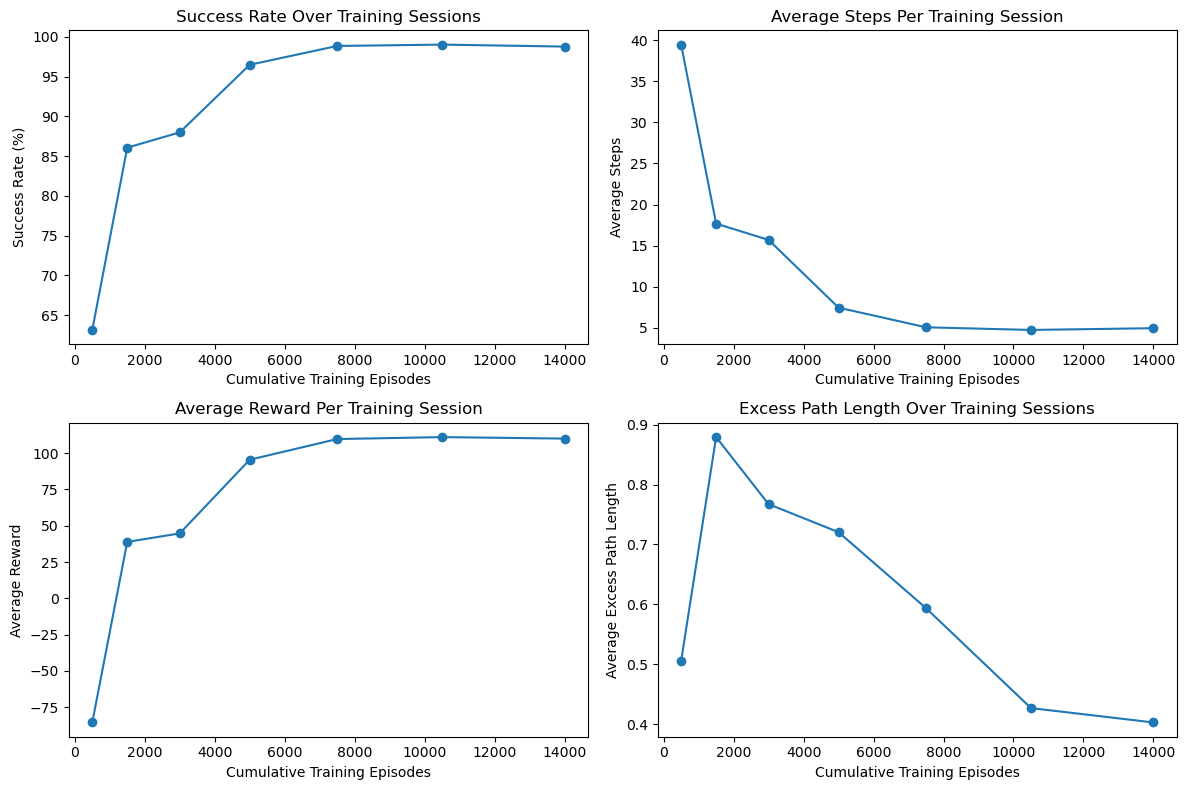

In [8]:
env = GridWorld(size=5, num_agents=4)
state_size = 9
action_size = 5
num_agents = env.num_agents
agent_types = env.agent_types
progress_list = [500, 1000, 1500, 2000, 2500, 3000, 3500]

multiagent = MultiAgentDeepQ(state_size, action_size, num_agents, agent_types)
train_and_evaluate(multiagent, env, progress_list, max_steps=15, num_tests=10000)

The agents showed rapid improvement in their task completion, especially in terms of success rate and efficiency. By around 8000 episodes, they had learned optimal strategies for completing the task with fewer steps and maximizing rewards. The decrease in excess path length towards the end suggests that the agents continued refining their paths to be as direct as possible.

#### Test 2: Generalization Ability Test

This test evaluates the agents’ ability to handle all possible starting conditions and task scenarios within the same grid configuration in a **multiagent environment**. By testing the agents on every possible variation, including different starting positions, target locations, and agent interactions, we assess whether the learned policies are robust and can generalize across all situations encountered in the environment. The aim is to evaluate whether the agents’ strategies can flexibly adapt and maintain coordination across varying configurations, ensuring that collaboration remains effective under diverse conditions.

#### Test Procedure

In this test, each agent is evaluated across all possible combinations of starting positions, target locations, and potential interactions with other agents within the same grid configuration. The exploration rate is set to zero (epsilon = 0), so that the agents rely entirely on their learned policies for decision-making. This allows us to measure the agents’ ability to apply their knowledge without further learning. Key performance metrics, such as overall success rate and excess path length, are recorded to assess consistency and collaboration under different scenarios.

#### Expected Behavior

In a well-generalized **multiagent** system, the agents are expected to coordinate efficiently and perform consistently well across all possible task configurations. High success rates and low excess path lengths across scenarios indicate that the agents’ policies are flexible and robust. If agents struggle in specific starting conditions or fail to coordinate under certain configurations, this could suggest overfitting to specific situations encountered during training, or that the agents’ collaborative strategies are insufficiently generalized across all possible multiagent scenarios.

In [9]:
def test_agent(multiagent, env, max_steps=15, csv_filename="test_failures.csv"):
    """
    Test the multi-agent system in the given environment by evaluating all unique combinations
    of agent positions, agent types [0, 1, 0, 1], and target positions. The function calculates 
    the performance level and average excess path length. It exports
    the initial and final agent locations and target location to a CSV file only when the task
    is not completed (i.e., done=False).
    """
    total_success = 0
    total_excess_path_length = 0
    total_cases = 0

    grid_size = env.size
    agent_positions = [(x, y) for x in range(grid_size) for y in range(grid_size)]

    # Set epsilon to 0 for all agents in the multi-agent system to ensure deterministic behavior
    for agent in multiagent.agents.values():
        agent.epsilon = 0

    # Open the CSV file for writing results (only failed cases)
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header row
        writer.writerow(["Initial Agent Locations", "Final Agent Locations", "Target Location"])

        # Iterate through all unique combinations of positions for agents of type 0 (Type 1 agents)
        for pos1 in agent_positions:
            for pos3 in agent_positions:
                if pos3 < pos1:  # Ensure unique combination by enforcing pos3 >= pos1
                    continue

                # Iterate through all unique combinations of positions for agents of type 1 (Type 2 agents)
                for pos2 in agent_positions:
                    for pos4 in agent_positions:
                        if pos4 < pos2:  # Ensure unique combination by enforcing pos4 >= pos2
                            continue

                        # Iterate through all possible target positions in the grid
                        for target_pos in agent_positions:
                            if target_pos not in [pos1, pos2, pos3, pos4]:
                                # Set the initial agent locations and target location
                                env.agent_locations = [pos1, pos2, pos3, pos4]
                                env.target_location = target_pos

                                initial_agent_locations = env.agent_locations.copy()

                                # Initialize other state variables
                                env.agent_has_secret = [False] * env.num_agents
                                env.done = False

                                # Manually retrieve the initial state 
                                states = env._get_state()
                                done = False
                                steps = 0

                                # Compute the minimal path length for the current configuration
                                min_path_length = compute_minimal_path_length(env)
                                min_path_length = max(min_path_length, 1)  # Ensure minimal path length is at least 1

                                # Agents operate until the task is done or the step limit is reached
                                while not done and steps < 100:
                                    actions = multiagent.get_actions(states)
                                    next_states, _, dones, _ = env.step(actions)
                                    states = next_states
                                    steps += 1
                                    done = any(dones)  # Check if any agent has completed the task

                                # Record the final agent locations after the task
                                final_agent_locations = env.agent_locations.copy()

                                if done:
                                    excess_path_length = max(steps - min_path_length, 0)
                                    total_excess_path_length += excess_path_length
                                    if steps < max_steps:
                                        total_success += 1
                                # If the task is not completed within the step limit, log to CSV
                                else:
                                    # Write data to CSV for failure cases only
                                    writer.writerow([initial_agent_locations, final_agent_locations, target_pos])

                                total_cases += 1

    # Print the total number of cases tested
    print(f'Total cases tested: {total_cases}')

    # Calculate performance metrics
    performance_level = (total_success / total_cases) * 100
    average_excess_path_length = total_excess_path_length / total_cases

    # Print the performance metrics
    print(f'Performance Level: {performance_level:.2f}%')
    print(f'Average Excess Path Length: {average_excess_path_length:.2f}')

    return performance_level, average_excess_path_length

In [ ]:
# Initialize environment and agents
env = GridWorld(size=5, num_agents=4)
state_size = 9  # Number of state features
action_size = 5  # Number of actions, including 'stay'
num_agents = env.num_agents
agent_types = env.agent_types

# Initialize MultiAgentDeepQ
multiagent = MultiAgentDeepQ(state_size, action_size, num_agents, agent_types)

# Train the agents
train_multiagent(multiagent, env, episodes=10000, max_steps=15)

Episode 100/10000 completed in 11.24s, epsilon: 0.606
Episode 200/10000 completed in 7.87s, epsilon: 0.367
Episode 300/10000 completed in 6.56s, epsilon: 0.222
Episode 400/10000 completed in 6.00s, epsilon: 0.135
Episode 500/10000 completed in 5.14s, epsilon: 0.100
Episode 600/10000 completed in 5.76s, epsilon: 0.100
Episode 700/10000 completed in 5.59s, epsilon: 0.100
Episode 800/10000 completed in 5.46s, epsilon: 0.100
Episode 900/10000 completed in 4.97s, epsilon: 0.100
Episode 1000/10000 completed in 5.32s, epsilon: 0.100
Episode 1100/10000 completed in 4.76s, epsilon: 0.100
Episode 1200/10000 completed in 5.59s, epsilon: 0.100
Episode 1300/10000 completed in 5.47s, epsilon: 0.100
Episode 1400/10000 completed in 4.26s, epsilon: 0.100
Episode 1500/10000 completed in 4.86s, epsilon: 0.100
Episode 1600/10000 completed in 4.67s, epsilon: 0.100
Episode 1700/10000 completed in 4.59s, epsilon: 0.100
Episode 1800/10000 completed in 4.53s, epsilon: 0.100
Episode 1900/10000 completed in 4.91

In [ ]:
env = GridWorld(size=5, num_agents=4)
performance_level, average_excess_path_length = test_agent(multiagent, env, max_steps=15)

Total cases tested: 2250000
Performance Level: 99.65%
Average Excess Path Length: 0.33


- These metrics show that the agents have learned effective policies that generalize well to unseen scenarios. The high performance level of **99.65%** indicates that the agents are capable of completing tasks successfully in nearly all configurations.
- The excess path length indicates that the agents are performing their tasks with a high degree of efficiency, although there is still some room for improvement in terms of finding the most optimal paths in every case.

***

### 6. Visualisation

#### Function Overview

The `visualise_episode` function provides a dynamic, step-by-step visual representation of the agent’s movements within the grid world during an episode. This visualisation is essential for understanding how the multi-agent system navigates, exchanges secrets, and reaches its objectives. The function animates the agents’ positions over time, showing how they interact with the environment and with each other.

**Parameters**:

- `agent`: The multi-agent system interacting with the environment. It determines the actions taken by each agent at every time step.
- `env`: The grid world environment where agents operate. The environment includes elements like agents, targets, and rewards.
- `cumulative_episodes`: Number of episodes the agents have been trained for. This value is displayed in the figure title.
- `interval`: Time (in milliseconds) between each frame in the animation.
- `step_limit`: Maximum number of steps the agents can take in one episode.

#### Function Breakdown

**Environment Reset and Initial State Setup**:

At the start of the episode, the environment is reset using `env.reset()`, and the agents are placed in new positions. The function prints the initial locations of the agents and the drop-off location (target). This information gives a clear understanding of where the agents begin and where they need to go.

**Colormap and Figure Setup**:

A custom colormap is defined to visually differentiate the elements on the grid:

- **Type 0 Agent (T0)**: Green
- **Type 1 Agent (T1)**: Red
- **Target (T)**: Gray
- **Agent with Secret (S)**: Cyan
- **Agent at Target with Secret (S at T)**: Magenta

A figure is created using Matplotlib, with grid lines that represent the structure of the environment.

**Animation Function (animate)**:

The core of the visualisation is handled by the animate function, which is called repeatedly to update the agents’ positions and the state of the grid world.

- **Initial Setup (i == 0)**: On the first iteration (`i == 0`), the function places the agents on the grid based on their starting locations and types. If two agents (Type 0 and Type 1) are in the same location, the function marks them both as having the “secret” and displays them as `S`. The grid is then updated to reflect these states.
- **Subsequent Steps**: As the episode progresses, the agents take actions based on the policy learned by the agent system. The environment transitions to the next state, and the agents’ positions are updated. If an agent with the secret reaches the target, it is displayed as `S at T`. The function keeps track of the rewards and steps taken during the episode.

**Grid Updates and Labels**:

After each time step, the grid is re-drawn to reflect the current positions of the agents and the target. The function applies labels (T0, T1, S, S at T) to clearly indicate the status of each agent on the grid.

**Completion and Summary**:

The episode ends when either all agents complete the task or the step limit is reached. If the agents complete the task successfully, a success message is displayed on the grid, and the grid is updated to show the agent with the secret at the target (`S at T`). If the agents fail to complete the task within the step limit, a failure message is displayed.

**Legend and Visualization**:

A legend is included on the right side of the figure to help interpret the colors and labels on the grid. The animation is displayed using `plt.show()`, providing a clear visual representation of the agents’ actions and interactions throughout the episode.

In [10]:
def visualise_episode(agent, env, cumulative_episodes, interval=500, step_limit=15):
    # Reset the environment to start a new episode
    states = env.reset()
    done = False
    episode_steps = 0
    episode_reward = 0  # Initialize episode reward

    # Capture initial positions for printing
    initial_agent_locations = env.agent_locations  # Get initial agent locations
    drop_off_location = env.target_location        # Get target location

    # Print the initial locations and episode information
    print(f"Initial Agent Locations: {initial_agent_locations}")
    print(f"Drop-Off Location (B): {drop_off_location}")

    # Compute minimal path length for performance comparison
    min_path_length = compute_minimal_path_length(env)

    # Define a custom colormap
    cmap = ListedColormap(['white', 'green', 'red', 'gray', 'cyan', 'magenta', 'orange'])

    # Create the figure for visualisation
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xticks(np.arange(-0.5, env.size, 1))
    ax.set_yticks(np.arange(-0.5, env.size, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, color='black')  # Set grid lines to black
    ax.set_aspect('equal')

    # Set the background color to white
    ax.set_facecolor('white')

    # Add a title to the figure
    fig.suptitle(f'Grid World - Trained {cumulative_episodes} Episodes', fontsize=16)

    # Define the legend patches
    legend_patches = [
        mpatches.Patch(color='green', label='Type 0 Agent'),
        mpatches.Patch(color='red', label='Type 1 Agent'),
        mpatches.Patch(color='gray', label='Target'),
        mpatches.Patch(color='cyan', label='Agent with Secret'),
        mpatches.Patch(color='magenta', label='Agent at Target with Secret'),
    ]

    # Animate the grid world for each step in the episode
    def animate(i):
        nonlocal states, episode_steps, done, episode_reward

        if i == 0:
            grid = np.zeros((env.size, env.size))

            # First, reset secret status for all agents
            for idx in range(len(env.agent_locations)):
                env.agent_has_secret[idx] = False  # Reset secret status

            # Check if any agents are at the same location
            for idx, agent_loc in enumerate(env.agent_locations):
                if env.agent_types[idx] == 0:  # Type 0 agent
                    for other_idx, other_loc in enumerate(env.agent_locations):
                        if other_idx != idx and tuple(agent_loc) == tuple(other_loc) and env.agent_types[other_idx] == 1:
                            env.agent_has_secret[idx] = True  # Assign secret to both agents
                            env.agent_has_secret[other_idx] = True
                            grid[tuple(agent_loc)] = 4  # Mark the grid as S (agent with secret)
                # If no secret has been assigned, assign the agent type normally
                if not env.agent_has_secret[idx]:
                    if env.agent_types[idx] == 0:
                        grid[tuple(agent_loc)] = 1  # Type 0 agent
                    elif env.agent_types[idx] == 1:
                        grid[tuple(agent_loc)] = 2  # Type 1 agent

            # Set the target location if it’s not already occupied by an agent with secret
            if not any([env.agent_has_secret[idx] and tuple(env.agent_locations[idx]) == tuple(env.target_location) 
                        for idx in range(len(env.agent_locations))]):
                grid[tuple(env.target_location)] = 3  # Target location

            ax.imshow(grid, cmap=cmap, vmin=0, vmax=6)

            # Annotate the grid with labels but no color changes
            for (j, i), label in np.ndenumerate(grid):
                if label == 1:  # Type 0 agent
                    ax.text(i, j, 'T0', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 2:  # Type 1 agent
                    ax.text(i, j, 'T1', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 3:  # Target location
                    ax.text(i, j, 'T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 4:  # Agent with secret
                    ax.text(i, j, 'S', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

            ax.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.36, 0.85), fontsize='11')

            return

        # Continue the episode if the task is not finished and step limit is not reached
        if not done and episode_steps < step_limit:
            actions = agent.get_actions(states)  # Get actions for all agents
            next_states, rewards, dones, _ = env.step(actions)  # Perform step in environment

            episode_steps += 1
            episode_reward += sum(rewards)  # Sum rewards across all agents
            states = next_states
            done = any(dones)  # If any agent completes the task, mark as done

            # Create the grid to visualize
            grid = np.zeros((env.size, env.size))

            # Place the agents on the grid
            for idx, agent_loc in enumerate(env.agent_locations):
                if env.agent_has_secret[idx]:
                    if tuple(agent_loc) == tuple(env.target_location):
                        grid[tuple(agent_loc)] = 5  # Agent at target with secret
                    else:
                        grid[tuple(agent_loc)] = 4  # Agent with secret
                else:
                    if env.agent_types[idx] == 0:
                        if grid[tuple(agent_loc)] == 2:  # If T1 is already in the same location
                            grid[tuple(agent_loc)] = 4  # Convert to S (agent with secret)
                        else:
                            grid[tuple(agent_loc)] = 1  # Type 0 agent
                    else:
                        if grid[tuple(agent_loc)] == 1:  # If T0 is already in the same location
                            grid[tuple(agent_loc)] = 4  # Convert to S (agent with secret)
                        else:
                            grid[tuple(agent_loc)] = 2  # Type 1 agent

            grid[tuple(env.target_location)] = 3  # Target location

            ax.clear()
            ax.imshow(grid, cmap=cmap, vmin=0, vmax=6)

            # Reapply grid lines and labels after clearing
            ax.set_xticks(np.arange(-0.5, env.size, 1))
            ax.set_yticks(np.arange(-0.5, env.size, 1))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(True, color='black')
            ax.set_facecolor('white')

            # Annotate the grid with labels
            for (j, i), label in np.ndenumerate(grid):
                if label == 1:  # Type 0 agent
                    ax.text(i, j, 'T0', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 2:  # Type 1 agent
                    ax.text(i, j, 'T1', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 3:  # Target location
                    ax.text(i, j, 'T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 4:  # Agent with secret
                    ax.text(i, j, 'S', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 5:  # Agent at target with secret
                    ax.text(i, j, 'S at T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

            ax.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.36, 0.85), fontsize='11')

        # Stop the animation if the task is finished or the maximum steps are reached
        if done or episode_steps == step_limit:
            deviation = episode_steps - min_path_length
            if episode_steps == step_limit:
                print(f"*** After {cumulative_episodes} episodes of training, agents did not complete the task within {step_limit} steps.\n")
                ax.text(0.5, 0.5, f'Failed to complete within {step_limit} step limit!',
                        ha='center', va='center', transform=ax.transAxes, fontsize=20,
                        color='red', fontweight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))
            elif done:
                print(f"*** After {cumulative_episodes} episodes of training, agents completed the task.")
                ax.text(0.5, 0.5, 'Task Completed Successfully!',
                        ha='center', va='center', transform=ax.transAxes, fontsize=20,
                        color='blue', fontweight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'))

                # Update target color once task is completed by an agent with the secret
                grid[tuple(env.target_location)] = 5  # Mark the target as successfully reached with secret

                # Redraw the final frame with updated colors
                ax.clear()
                ax.imshow(grid, cmap=cmap, vmin=0, vmax=6)
                ax.set_xticks(np.arange(-0.5, env.size, 1))
                ax.set_yticks(np.arange(-0.5, env.size, 1))
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.grid(True, color='black')
                ax.set_facecolor('white')

                # Annotate the grid with labels
                for (j, i), label in np.ndenumerate(grid):
                    if label == 1:  # Type 0 agent
                        ax.text(i, j, 'T0', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                    elif label == 2:  # Type 1 agent
                        ax.text(i, j, 'T1', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                    elif label == 3:  # Target location
                        ax.text(i, j, 'T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                    elif label == 4:  # Agent with secret
                        ax.text(i, j, 'S', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                    elif label == 5:  # Agent at target with secret
                        ax.text(i, j, 'S at T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

                ax.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.36, 0.85), fontsize='11')

            anim.event_source.stop()  # Stop the animation when done
            plt.draw()  # Force a draw of the current figure to ensure the last frame is rendered

            plt.pause(2)  # Short pause to ensure the rendering occurs
            plt.close(fig)  # Automatically close the figure window

    # Create the animation
    anim = FuncAnimation(fig, animate, interval=interval, frames=100)
    plt.show()

In [11]:
episodes = 10000
step_limit = 15  # Define the step limit based on the environment's size and constraints

# Initialise the environment and agent
env = GridWorld(size=5, num_agents=4)  # Assuming 5x5 grid and 4 agents (2 of each type)
state_size = 9  # Each agent's state (position, direction, possession status)
action_size = 5  # Four actions (north, south, west, east) + stay
num_agents = env.num_agents
agent_types = env.agent_types

# Initialise the multi-agent deep Q-learning system
multiagent = MultiAgentDeepQ(state_size=state_size, action_size=action_size, num_agents=num_agents, agent_types=agent_types)

train_multiagent(multiagent, env, episodes=episodes, max_steps=step_limit)  # Pass step_limit to the training function
print(f"--- After {episodes} Training Episodes Test Visualisation and Summary ---")

for _ in range (5):
    visualise_episode(multiagent, env, episodes, step_limit=step_limit, interval=2500)  # Pass step_limit to the visualisation function

Episode 100/10000 completed in 8.05s, epsilon: 0.606
Episode 200/10000 completed in 6.17s, epsilon: 0.367
Episode 300/10000 completed in 5.19s, epsilon: 0.222
Episode 400/10000 completed in 5.57s, epsilon: 0.135
Episode 500/10000 completed in 5.12s, epsilon: 0.100
Episode 600/10000 completed in 4.67s, epsilon: 0.100
Episode 700/10000 completed in 4.50s, epsilon: 0.100
Episode 800/10000 completed in 4.39s, epsilon: 0.100
Episode 900/10000 completed in 4.03s, epsilon: 0.100
Episode 1000/10000 completed in 3.95s, epsilon: 0.100
Episode 1100/10000 completed in 4.10s, epsilon: 0.100
Episode 1200/10000 completed in 3.93s, epsilon: 0.100
Episode 1300/10000 completed in 4.08s, epsilon: 0.100
Episode 1400/10000 completed in 3.99s, epsilon: 0.100
Episode 1500/10000 completed in 4.42s, epsilon: 0.100
Episode 1600/10000 completed in 4.40s, epsilon: 0.100
Episode 1700/10000 completed in 4.62s, epsilon: 0.100
Episode 1800/10000 completed in 4.18s, epsilon: 0.100
Episode 1900/10000 completed in 4.51s

***

### 7. Game Theoretic Analysis of Agents' Travel Distance Problem

#### Modeling the Scenario

In this scenario, we are tasked with analyzing the interaction between two agents using **game theory**. The agents are trying to meet at a common point on a grid, and the goal is to model the scenario in a simplified manner, allowing us to observe the key decision-making effects. Instead of using a larger grid like 5x5, we can use a smaller grid such as **3x3** to simplify the analysis.

#### Payoff Matrix and Analysis

We model the game by defining a payoff matrix based on the **Manhattan distance** between each agent’s starting position and their selected meeting point. In the 3x3 grid, we assume the agents start from specific positions, and there is a **target point** on the grid that neither agent can choose as their meeting point.

$$
\begin{matrix}
(0,0) & (0,1) & (0,2) \\
(1,0) & (1,1) & (1,2) \\
(2,0) & (2,1) & (2,2)
\end{matrix}
$$

The grid layout and agents’ starting positions are as follows:
- Agent A starts at $(0, 0)$
- Agent B starts at $(2, 2)$
- The target is at $(1, 1)$

We then calculate the Manhattan distances for each possible meeting point (excluding the target) and construct the following **payoff matrix**, where each cell contains the payoffs for Agent A and Agent B respectively:

$$
\begin{bmatrix}
(0, -4) & (-1, -3) & (-2, -2) \\
(-1, -3) & \text{-} & (-3, -1) \\
(-2, -2) & (-3, -1) & (-4, 0)
\end{bmatrix}
$$

Each cell represents the payoffs for the agents if they choose that specific meeting point.

#### Nash Equilibrium and Fairness

A Nash equilibrium occurs when neither agent can improve their payoff by unilaterally changing their strategy. In this case, the meeting point $(0, 2)$ and $(2, 0)$ provide a **Nash equilibrium** with equal payoffs of $(-2, -2)$. Both agents travel an equal distance, which ensures fairness in the solution, and neither agent has an incentive to choose a different meeting point.

#### Comparative Analysis: Q-learning vs. Game Theory

**Game Theory** offers a structured and analytical approach to finding equilibria and understanding fairness. In this scenario, it predicts that the agents will converge on the meeting point that minimizes distance inequality. Game theory is particularly useful for deriving **optimal, fair outcomes** in simple, static environments where agents can evaluate all possible strategies.

However, **game theory** relies on the assumption that agents are fully rational and have complete knowledge of each other’s strategies, which may not always be realistic in complex, dynamic environments.

**Q-learning**, on the other hand, provides a way for agents to **adaptively learn** optimal strategies through trial and error. This is especially useful in environments with uncertainty or where agents lack full knowledge. By interacting with the environment over time, agents learn which strategies yield the best rewards. Q-learning is more flexible and can handle **dynamic and complex** scenarios where agents may need to react to changing environments or incomplete information.

However, Q-learning might not **naturally converge** on a fair solution unless fairness is explicitly incorporated into the reward structure. Without such a fairness constraint, agents might focus solely on optimizing their individual rewards rather than seeking an equal distribution of travel costs.

#### Conclusion

Both **Q-learning** and **game theory** offer valuable insights into the agents’ decision-making processes, but they serve different purposes. **Game theory** excels in analyzing fairness and equilibrium behavior in structured, well-defined environments, while **Q-learning** is better suited for adaptive learning in dynamic or uncertain environments. Each method covers different aspects of agent behavior, and combining both approaches may offer a more comprehensive understanding of the agents’ strategies and outcomes.

***

### 8. Conclusion and Limitations

In this project, the Deep Q-learning agents successfully demonstrated their ability to efficiently solve a multiagent grid-world task by learning to navigate, exchange information, and complete objectives with minimal steps. The agents’ performance, as reflected in high success rates and low excess path lengths, showcased their capacity to adapt and perform well in both learning and generalization tests. The use of neural network-based Q-value approximation proved to be effective in handling larger state spaces and scaling to more complex environments, overcoming the limitations of traditional tabular Q-learning approaches.

However, several limitations emerged during the project that provide opportunities for further improvement:

1. **Hyperparameter Sensitivity**: The performance of the agents was particularly sensitive to key hyperparameters such as the learning rate, discount factor, and replay buffer size. Optimizing these parameters required extensive experimentation and careful fine-tuning. Future work could explore automated hyperparameter tuning methods, such as grid search, random search, or more advanced techniques like Bayesian optimization, to streamline the tuning process and potentially uncover more optimal configurations.
2. **Fairness and Coordination**: While the agents were able to optimize their individual objectives effectively, the game-theoretic analysis revealed a lack of fairness and coordination, particularly in terms of distance traveled and task sharing. In some cases, one agent might take on more work, leading to imbalanced task loads. To address this, incorporating fairness constraints or cooperative reward structures could be an area for future exploration. Implementing a mechanism to encourage more equitable task distribution, such as shared rewards or penalties for inefficient collaboration, could result in more balanced strategies and improve overall system efficiency.

### 9. Acknowledgement

I utilised ChatGPT (OpenAI, 2024) to summarise the code and review the grammar in my work. The output was subsequently adjusted to better align with my writing style.

### 10. References

OpenAI. (2024). ChatGPT (Version 1.2024.227) [Large language model]. Accessed 15 September 2024. https://chatgpt.com/